# Example of usage Spark OCR with http source

## Install spark-ocr python packge
Need specify path to `spark-ocr-assembly-[version].jar` or `secret`

In [1]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"

In [ ]:
# install from PYPI using secret
#%pip install spark-ocr==$version+spark32 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade
%pip install requests

In [ ]:
# or install from local path
# %pip install ../dist/spark-ocr-4.0.0+spark32.tar.gz

## Initialization of spark session

In [ ]:
from pyspark.sql import SparkSession
from sparkocr import start
import os

if license:
    os.environ['JSL_OCR_LICENSE'] = license

spark = start(secret=secret, jar_path=spark_ocr_jar_path)
spark

## Import OCR transformers

In [10]:
import requests
import io
from sparkocr.transformers import *
from sparkocr.utils import *
from pyspark.ml import PipelineModel

# Example with PDF
## Define OCR transformers and pipeline

In [4]:
def pipeline():
    
    # Transforrm PDF document to images per page
    pdf_to_image = PdfToImage()
    pdf_to_image.setInputCol("content")
    pdf_to_image.setOutputCol("image")

    # Run OCR
    ocr = ImageToText()
    ocr.setInputCol("image")
    ocr.setOutputCol("text")
    ocr.setConfidenceThreshold(65)
    
    pipeline = PipelineModel(stages=[
        pdf_to_image,
        ocr
    ])
    
    return pipeline

## Read PDF document by url

In [5]:
url = 'http://www.asx.com.au/asxpdf/20171103/pdf/43nyyw9r820c6r.pdf'
response = requests.get(url)
my_raw_data = response.content
pdf_content = io.BytesIO(my_raw_data)
pdf_example_df = spark.createDataFrame([("file1", bytearray(my_raw_data)),], ("path", "content"))
pdf_example_df.show()

+-----+--------------------+
| path|             content|
+-----+--------------------+
|file1|[25 50 44 46 2D 3...|
+-----+--------------------+



## Run OCR pipeline

In [6]:
result = pipeline().transform(pdf_example_df).cache()

## Display Original document


    Image #0:
    Origin: file1
    Resolution: 300 dpi
    Width: 2479 px
    Height: 3508 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


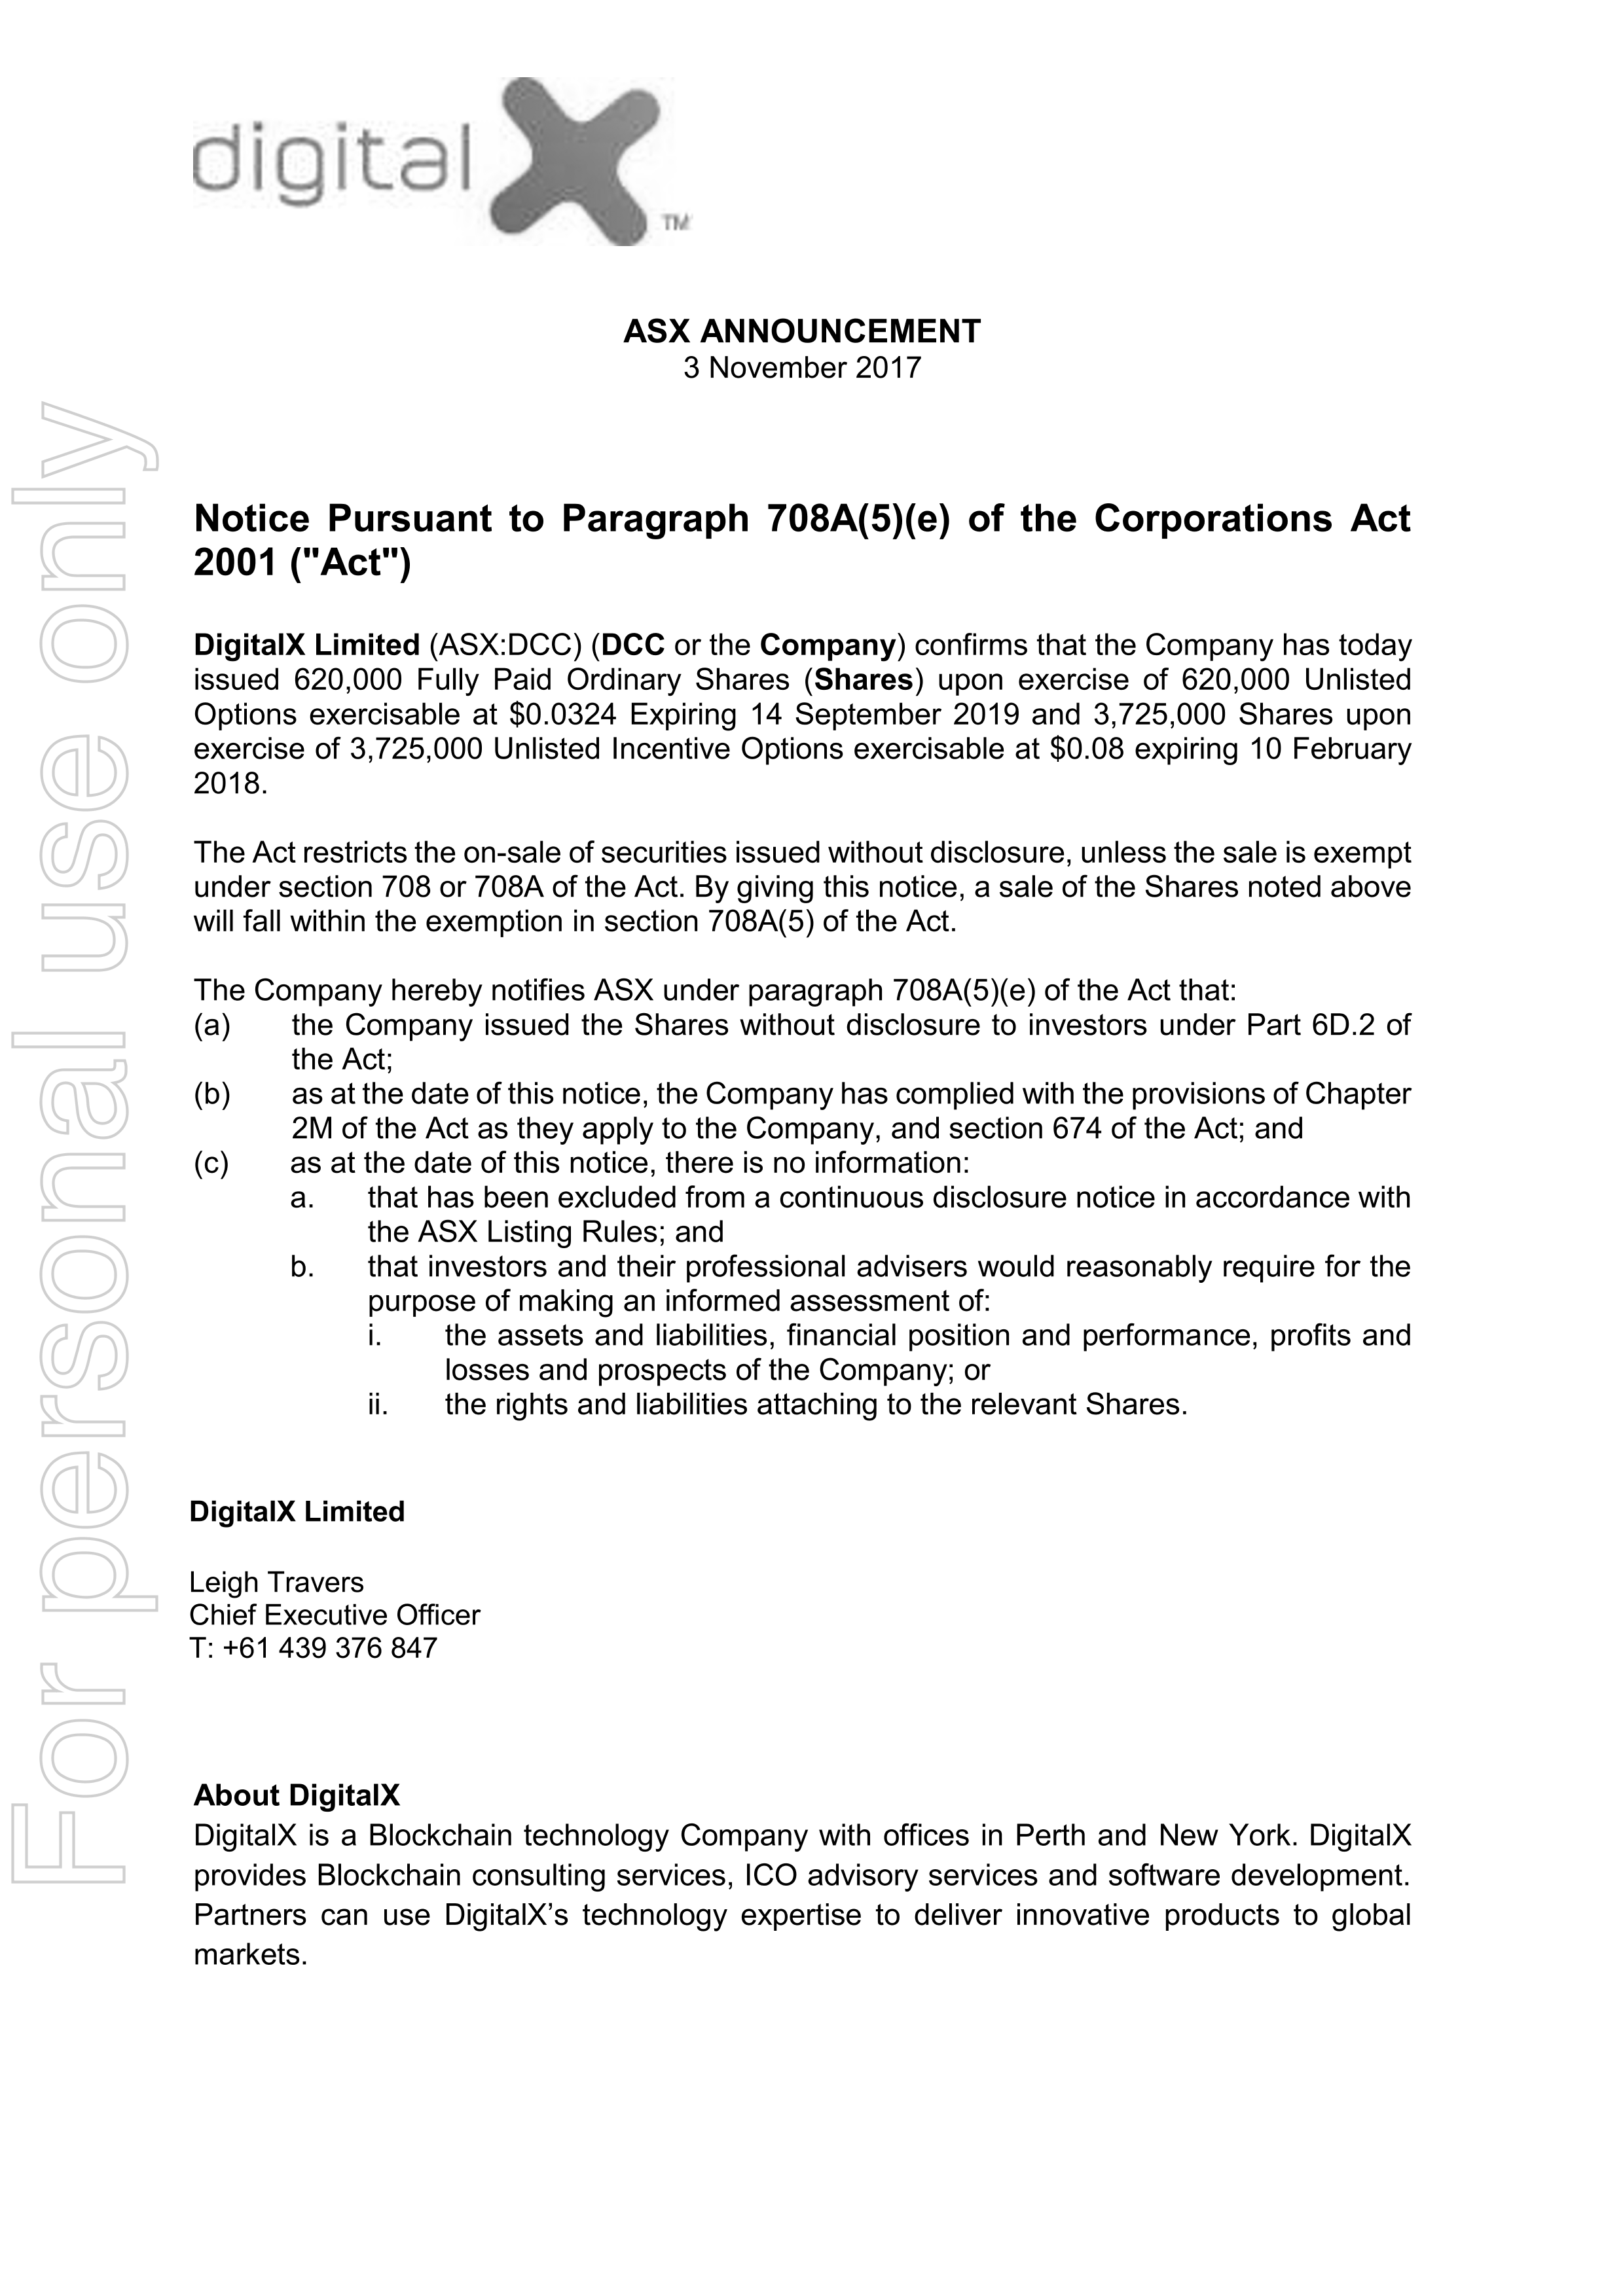

In [11]:
display_pdf(pdf_example_df)

## Display results

In [12]:
result.select("pagenum","text", "confidence").show()

+-------+--------------------+-----------------+
|pagenum|                text|       confidence|
+-------+--------------------+-----------------+
|      0|ASX ANNOUNCEMENT\...|95.62473392486572|
+-------+--------------------+-----------------+



### Display recognized text

In [13]:
print("\n".join([row.text for row in result.select("text").collect()]))

ASX ANNOUNCEMENT
3 November 2017

Notice Pursuant to Paragraph 708A(5)(e) of the Corporations Act
2001 ("Act")

DigitalX Limited (ASX:DCC) (DCC or the Company) confirms that the Company has today
issued 620,000 Fully Paid Ordinary Shares (Shares) upon exercise of 620,000 Unlisted
Options exercisable at $0.0324 Expiring 14 September 2019 and 3,725,000 Shares upon
exercise of 3,725,000 Unlisted Incentive Options exercisable at $0.08 expiring 10 February
2018.

The Act restricts the on-sale of securities issued without disclosure, unless the sale is exempt
under section 708 or 708A of the Act. By giving this notice, a sale of the Shares noted above
will fall within the exemption in section 708A(5) of the Act.

The Company hereby notifies ASX under paragraph 708A(5)(e) of the Act that:
(a) the Company issued the Shares without disclosure to investors under Part 6D.2 of
the Act;
(b) as at the date of this notice, the Company has complied with the provisions of Chapter
2M of the Act as they 

# Example with image
## Load image by url and create dataframe

In [14]:
url = "http://jeroen.github.io/images/testocr.png" #"https://www.w3.org/WAI/images/easychecks/contrast-gray-white.png"
response = requests.get(url)
my_raw_data = response.content
pdf_example_df = spark.createDataFrame([("file1", bytearray(my_raw_data)),], ("path", "content"))
pdf_example_df.show()

+-----+--------------------+
| path|             content|
+-----+--------------------+
|file1|[89 50 4E 47 0D 0...|
+-----+--------------------+



## Define OCR transformers and pipeline

In [15]:
def pipeline():
    
    # Transforrm PDF document to images per page
    binary_to_image = BinaryToImage()
    binary_to_image.setInputCol("content")
    binary_to_image.setOutputCol("image")

    # Run tesseract OCR
    ocr = ImageToText()
    ocr.setInputCol("image")
    ocr.setOutputCol("text")
    ocr.setConfidenceThreshold(65)
    
    pipeline = PipelineModel(stages=[
        binary_to_image,
        ocr
    ])
    
    return pipeline

## Run OCR pipeline

In [16]:
result = pipeline().transform(pdf_example_df).cache()

## Display original image


    Image #0:
    Origin: file1
    Resolution: 0 dpi
    Width: 640 px
    Height: 480 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


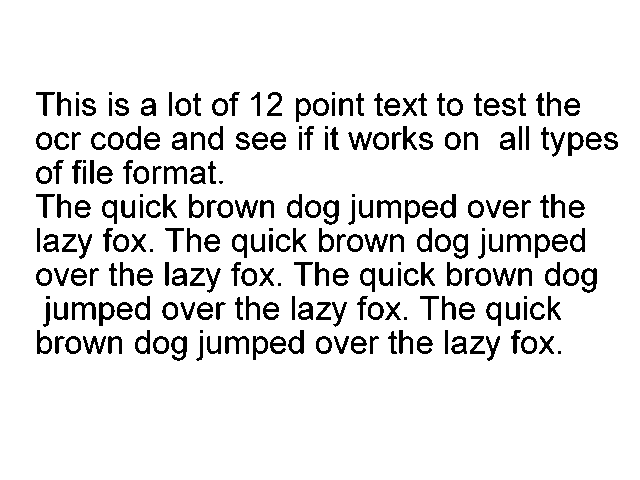

In [17]:
display_images(result)

## Display results

In [18]:
result.select("pagenum","text", "exception").show()

+-------+--------------------+---------+
|pagenum|                text|exception|
+-------+--------------------+---------+
|      0|This is a lot of ...|     null|
+-------+--------------------+---------+



In [19]:
print("\n".join([row.text for row in result.select("text").collect()]))

This is a lot of 12 point text to test the
ocr code and see if it works on all types
of file format.

The quick brown dog jumped over the
lazy fox. The quick brown dog jumped
over the lazy fox. The quick brown dog
jumped over the lazy fox. The quick
brown dog jumped over the lazy fox.



## Clear cache

In [20]:
result.unpersist()

image,path,pagenum,confidence,exception,text,positions
"{file1, 480, 640,...",file1,0,96.2665786743164,null,This is a lot of ...,[{[{This is a lot...
